# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re

warnings.filterwarnings('ignore')

In [ ]:
from pathlib import Path
from datetime import datetime
from tqdm import tqdm
from itertools import product
from functools import partial
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import wilcoxon

# Variables

In [3]:
BASE_TICKER_PATH = 'assets'

# Functions

In [4]:
def build_figure(rows, cols, width=6, height=4, constrained_layout=True, **kwargs):
    return plt.subplots(
        rows, cols,
        figsize=(cols * width, rows * height),
        constrained_layout=constrained_layout,
        **kwargs
    )

In [5]:
def extract_date_from(path):
    fields = [int(field) for field in path[-14:-4].split('-')]
    return datetime(*fields)

In [6]:
def extract_data_files_from(ticker):
    return sorted(
        [
            extract_date_from(str(path))
            for path in Path(f'{BASE_TICKER_PATH}/{ticker}').glob('*.csv')
        ]
    )

In [7]:
def load_data(ticker):
    data = pd.concat([
        pd.read_csv(
            f'{BASE_TICKER_PATH}/{ticker}/{str(date_).split()[0]}.csv'
        )
        for date_ in extract_data_files_from(ticker)
    ])

    data['Date'] = data['Date'].map(lambda v: v.split()[0])
    data = data.set_index('Date')
    data.index = pd.to_datetime(data.index, utc=True)
    return data

In [8]:
def loading_pipeline(ticker, features_functions):
    data = load_data(ticker)
    for feature_function in features_functions:
        data = feature_function(data)
    return data

In [13]:
def extract_number(input_string):
    # Use regular expressions to find the number
    number_pattern = r'\((\d+)'
    match = re.search(number_pattern, input_string)
    
    if match:
        # Extract the number from the matched pattern
        number = int(match.group(1))
        return number
    else:
        return None

In [14]:
def calculate_returns(data):
    data['Returns'] = np.log(data['Close'] / data['Close'].shift(1))
    return data

In [15]:
def volatility(data, window):
    q95 = data['Returns'].rolling(window).quantile(.95)
    q5 = data['Returns'].rolling(window).quantile(.05)
    data['Q95'] = q95
    data['Q5'] = q5
    data[f'Volatility ({window} days)'] = np.log((1 + q95) / (1 + q5))
    return data

In [16]:
def load_volatilities(ticker, volatility_functions):
    data = loading_pipeline(ticker, [calculate_returns, *volatility_functions])
    features = data[[col for col in data.columns if 'Volatility' in col]]
    return features.dropna()

In [17]:
def spot_future_volatility(data, feature_to_use, future_window):
    return data[feature_to_use].shift(-future_window)

In [18]:
def delta_future_volatility(data, feature_to_use, future_window):
    y = np.log(data[feature_to_use].shift(-future_window) / data[feature_to_use])
    return y[(y != np.inf) & (y != (-np.inf))]

In [19]:
def delta_future_volatility_categorical(data, feature_to_use, future_window):
    return np.log(data[feature_to_use].shift(-future_window) / data[feature_to_use]) > 0

In [20]:
def calculate_mi_scores(features, volatility_to_predict, future_window, y_build_function, mi_score_function):
    y = features[f'Volatility ({volatility_to_predict} days)'].shift(-future_window).dropna()
    y = y_build_function(features, f'Volatility ({volatility_to_predict} days)', future_window).dropna()
    X = features.loc[y.index]
    return pd.Series(mi_score_function(X, y), index=features.columns, name=f'Volatility ({volatility_to_predict} days) - Next {future_window} days')

In [21]:
def compare_results(data, column, short_window, long_window):
    return wilcoxon(
        data.loc[data[column] == short_window, 'MI'].values,
        data.loc[data[column] == long_window, 'MI'].values
    ).pvalue

# Main

### Questions

- Can volatility of longer windows predict/explain volatility of shorter windows better than the opposite?

### Code

In [22]:
A_MONTH = 21
short_windows = (2, 3, 5, 10)
long_windows = tuple(A_MONTH * i for i in (1, 3, 6, 12))
future_windows = (1, 3, 5, 10, A_MONTH, A_MONTH * 3, A_MONTH * 6)
all_windows = (*short_windows, *long_windows)
volatility_functions = [
    partial(volatility, window=window)
    for window in all_windows
]

In [23]:
tickers = (
    '^GSPC', 
    '^BVSP',
    '^N225',
    '^FTSE',
    '^GDAXI',
    'VWO',
    'AGG',
    'GLD',
    'BTC-USD',
    'TLT',
    'IEF',
    'VTI',
    'DBC',
)

In [25]:
for ticker in tickers:
    data = load_volatilities(ticker, volatility_functions)
    
    results = pd.DataFrame([
        calculate_mi_scores(data, window, future_window, spot_future_volatility, mutual_info_regression)
        for window, future_window in tqdm(product(all_windows, future_windows))
    ])
    
    results_2 = pd.DataFrame(results.stack()).reset_index()
    results_2.columns = ['Future Volatility', 'Actual Volatility', 'MI']
    results_2['Volatility (Actual)'] = results_2['Actual Volatility']
    results_2['Volatility (Future)'] = results_2['Future Volatility'].map(lambda v: v.split(' - ')[0])
    results_2['Future Days'] = results_2['Future Volatility'].map(lambda v: v.split(' - ')[1])
    results_2 = results_2[['Volatility (Actual)', 'Volatility (Future)', 'Future Days', 'MI']]
    results_2['VA'] = results_2['Volatility (Actual)'].map(lambda v: int(v.split('(')[-1].split()[0]))
    results_2['VF'] = results_2['Volatility (Future)'].map(lambda v: int(v.split('(')[-1].split()[0]))
    results_2['FD'] = results_2['Future Days'].map(lambda v: int(v.split()[1]))
    results_2['VA Kind'] = results_2['VA'].map(lambda v: 'Short' if v < 21 else 'Long')
    results_2['VF Kind'] = results_2['VF'].map(lambda v: 'Short' if v < 21 else 'Long')
    
    results_2.to_csv(f'results/{ticker}_results.csv')

56it [02:02,  2.19s/it]
56it [00:38,  1.44it/s]
56it [01:16,  1.36s/it]
56it [00:53,  1.05it/s]
56it [00:45,  1.22it/s]
56it [00:23,  2.41it/s]
56it [00:24,  2.29it/s]
56it [00:24,  2.29it/s]
56it [00:16,  3.43it/s]
56it [00:24,  2.30it/s]
56it [00:24,  2.27it/s]
56it [00:25,  2.18it/s]
56it [00:21,  2.57it/s]


In [26]:
plt.rcParams['font.size'] = 16
pallete = 'Set3'

In [27]:
summaries = []
for ticker in tqdm(tickers):    
    results_2 = pd.read_csv(f'Volatility Study/{ticker}_results.csv')
    results_2['Comparison'] = results_2['VA Kind'] + ' predicting ' + results_2['VF Kind']
    results_2 = results_2[results_2['VA Kind'] != results_2['VF Kind']]
    summary = results_2.sort_values(by='FD').groupby(['Comparison', 'Future Days']).agg({'MI': 'mean'}).reset_index()
    summary = summary.sort_values(by='Future Days', key=np.vectorize(lambda v: int(v.split()[1])))
    summary['Asset'] = ticker
    summaries.append(summary)

summaries = pd.concat(summaries).sort_values(by='Future Days', key=np.vectorize(lambda v: int(v.split()[1]))).reset_index(drop=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 72.72it/s]


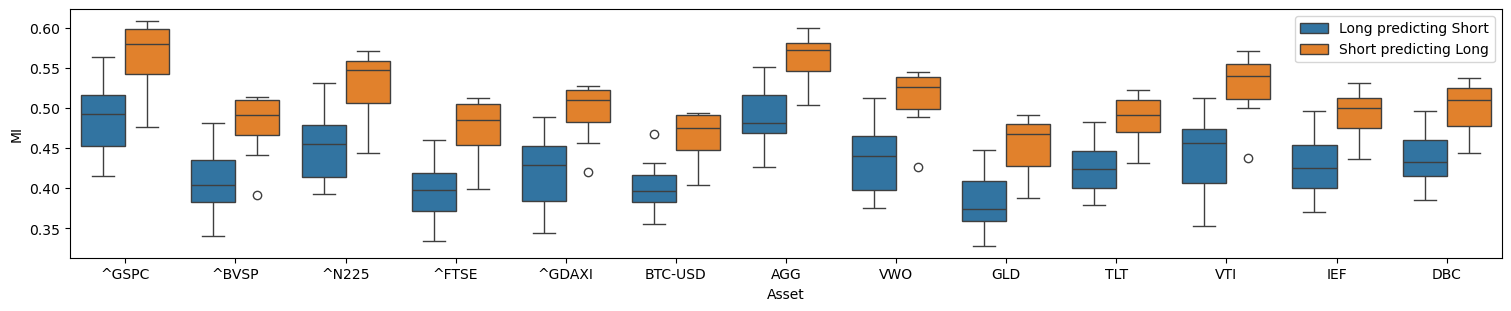

In [30]:
fig, ax = build_figure(1, 1, width=15, height=3)
plt.rcdefaults()
sns.boxplot(data=summaries, x='Asset', y='MI', hue='Comparison', ax=ax);
ax.legend(bbox_to_anchor=(1, 1));
fig.savefig(f'results/summary_comparison.png');

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.34it/s]


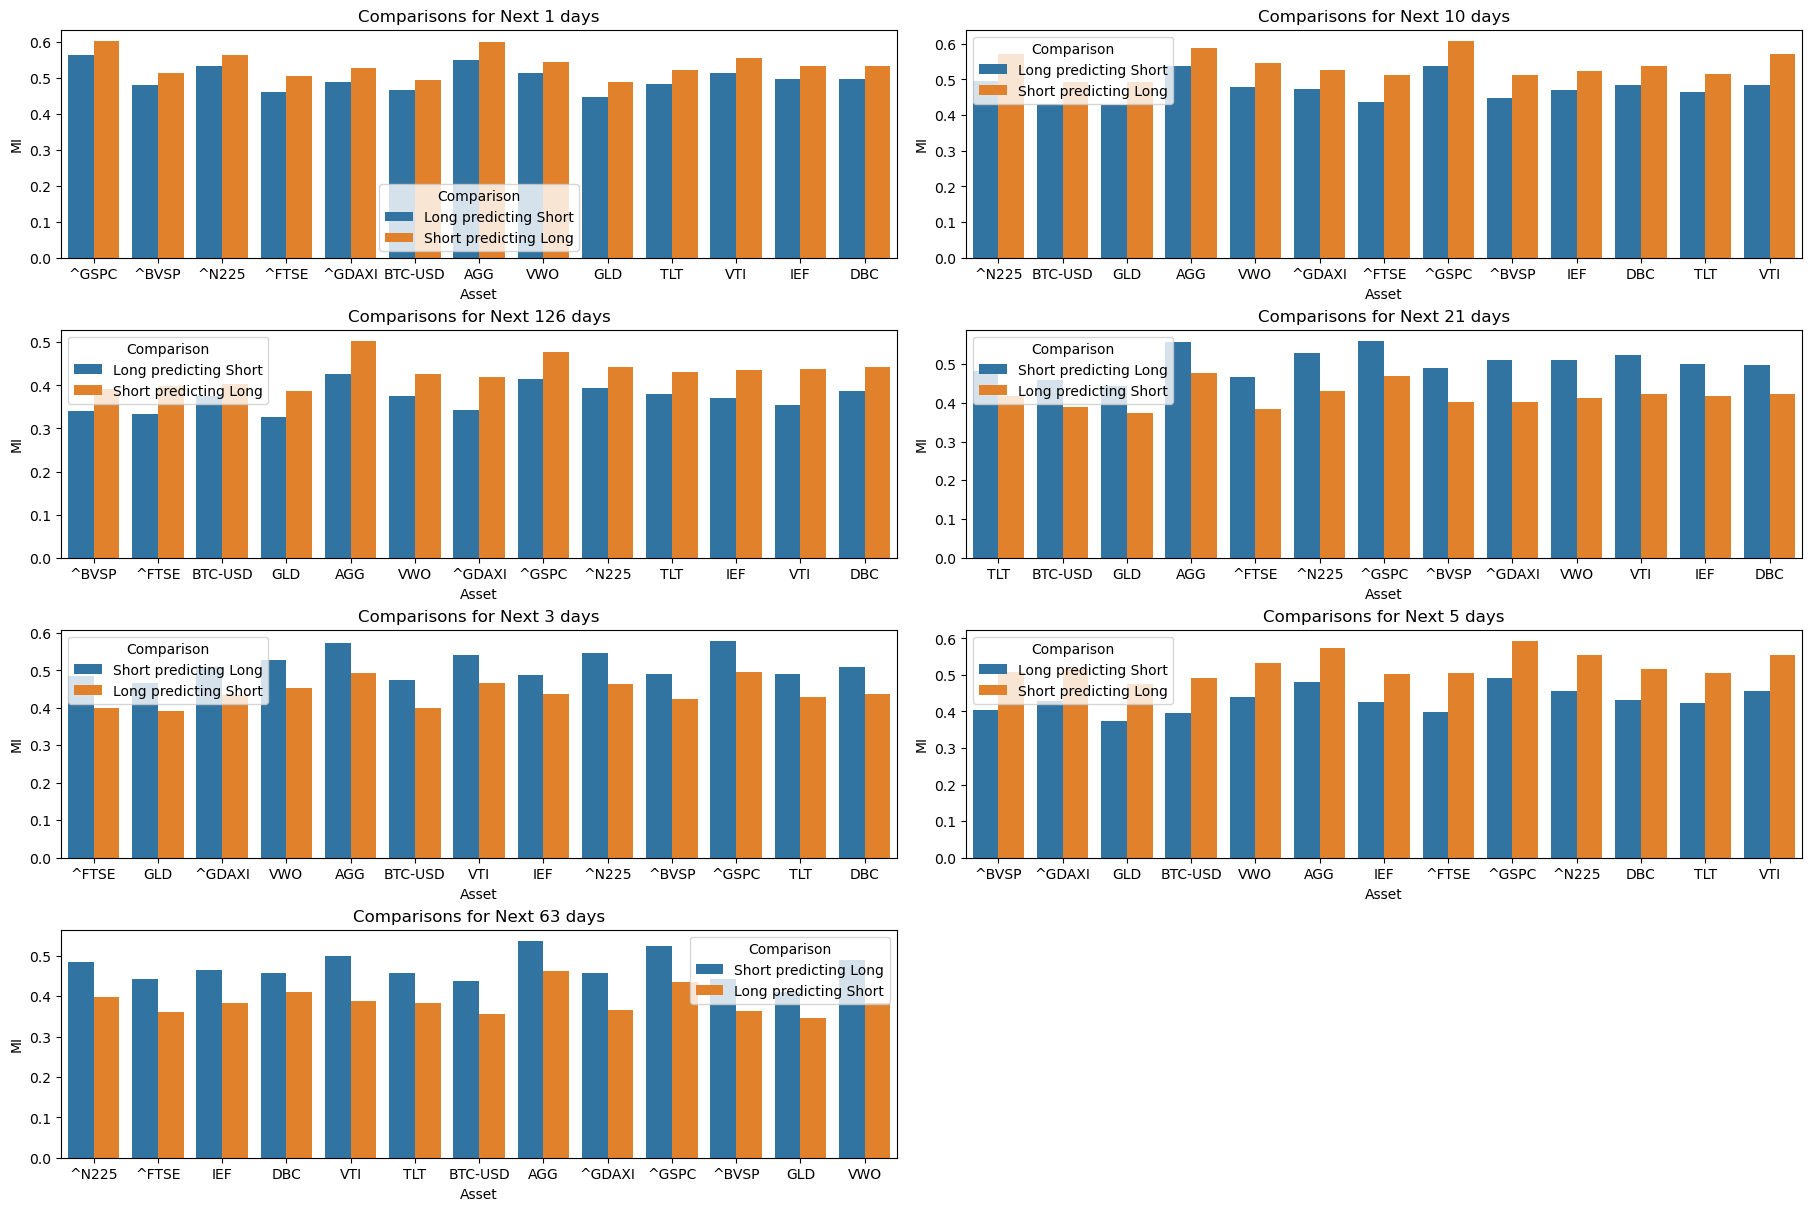

In [31]:
plt.rcdefaults()
fig, axs = build_figure(4, 2, width=9, height=3)
axit = iter(axs.ravel())

for time_scale, df in tqdm(summaries.groupby('Future Days')):
    ax = next(axit)
    sns.barplot(data=df, x='Asset', y='MI', hue='Comparison', ax=ax);
    ax.set_title(f'Comparisons for {time_scale}');

for ax in axit:
    ax.axis('off');

fig.savefig(f'results/summary_comparison.2.png');